In [1]:
import os
import random

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn

from utils.training import *
from utils.utils import *

from models.classification_model import ClassificationNet
from models.bert import *

sns.set(font_scale=1.3)
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [2]:
def seed_everything(seed=42):
    random.seed(seed)
    os.environ['PYTHONASSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True
    
seed_everything()

In [3]:
data = pd.read_csv('emotions_short.csv', index_col='Unnamed: 0')
data.head()

,Text,Emotion
0,im grabbing a minute to post i feel greedy wrong,anger
1,i am feeling grouchy,anger
2,i think it s the easiest time of year to feel ...,anger
3,i feel irritated and rejected without anyone d...,anger
4,i already feel like i fucked up though because...,anger


In [4]:
train_dataloader, val_dataloader, val_dataloader_shuffled = get_bert_dataloaders(data['Text'], data['Emotion'], shuffle=True)

  0%|          | 0/480 [00:00<?, ?it/s]

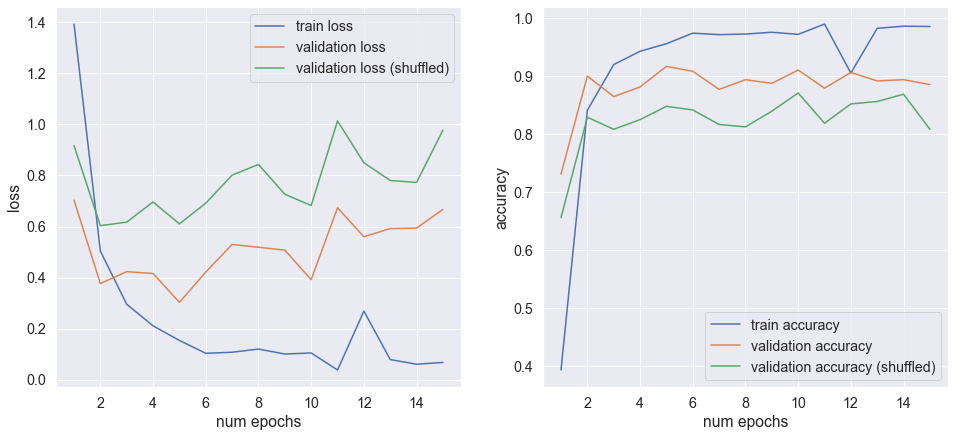

epoch number: 15
time per epoch: 43.284s
validation acc: 88.5
validation loss: 0.667


In [5]:
model = ClassificationModel(num_classes=6, hidden_size=384).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

model, history = bert_shuffled_training_loop(
    model, criterion, optimizer, train_dataloader, 
    val_dataloader, val_dataloader_shuffled, num_epochs=15,
    model_path_to_save='./weights/bert_shuffled.pth',
    history_path_to_save='./histories/bert_shuffled.csv',
    shuffled_model_path_to_save='./weights/bert_best_shuffled.pth',
    shuffled_history_path_to_save='./histories/bert_best_shuffled.pth'
)

In [31]:
label_encoder = LabelEncoder().fit(data['Emotion'])

In [32]:
model = ClassificationModel(num_classes=6, hidden_size=384).to(device)
model.load_state_dict(torch.load('./weights/bert_shuffled.pth'))
model.eval()

not_shuffled_pred = []
for val_batch in tqdm(val_dataloader):
        val_batch = {key: value.to(device) for key, value in val_batch.items()}
        input_ids, attention_mask = val_batch['input_ids'], val_batch['attention_mask']
        target = val_batch['target']
        predictions = model(input_ids, attention_mask)
        target = target.detach().cpu().numpy()
        predictions = predictions.detach().cpu().numpy().argmax(axis=1)
        not_shuffled_pred.extend(label_encoder.inverse_transform(predictions))
        
not_shuffled_pred = np.array(not_shuffled_pred)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


  0%|          | 0/30 [00:00<?, ?it/s]

In [33]:
model = ClassificationModel(num_classes=6, hidden_size=384).to(device)
model.load_state_dict(torch.load('./weights/bert_best_shuffled.pth'))
model.eval()

shuffled_pred = []
for val_batch in tqdm(val_dataloader_shuffled):
        val_batch = {key: value.to(device) for key, value in val_batch.items()}
        input_ids, attention_mask = val_batch['input_ids'], val_batch['attention_mask']
        target = val_batch['target']
        predictions = model(input_ids, attention_mask)
        target = target.detach().cpu().numpy()
        predictions = predictions.detach().cpu().numpy().argmax(axis=1)
        shuffled_pred.extend(label_encoder.inverse_transform(predictions))
        
shuffled_pred = np.array(shuffled_pred)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


  0%|          | 0/30 [00:00<?, ?it/s]

In [34]:
df = pd.DataFrame(np.hstack((not_shuffled_pred.reshape(-1, 1), shuffled_pred.reshape(-1, 1))))
df.columns = ['not shuffled', 'shuffled']
df.to_csv('shuffled_predictions.csv', index=False)